In [1]:
from tqdm import tqdm
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pickle as pkl

In [2]:
torch.cuda.is_available()

True

In [3]:
BATCH_SIZE = 32
EPOCHS = 100

In [4]:
otfs_data = scipy.io.loadmat('../data/OTFSData.mat')
otfs_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Rx', 'Tdata', 'chanParamsData', 'tdata', 'xdata'])

In [5]:
Tdata = otfs_data['Tdata'] # transmitted data
Rx = otfs_data['Rx'] # received data
Tdata.shape, Rx.shape

((64, 60, 10000), (10000, 4440))

In [6]:
n = Rx.shape[0]
indices = np.arange(n)
train_indices, test_indices = train_test_split(indices, test_size = 0.2, shuffle = True, random_state = 42)
train_indices.shape, test_indices.shape

((8000,), (2000,))

In [7]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
class ChannelEstimationDatasetCNNCEMSE(Dataset):
    def __init__(self, otfs_data, indices):
        self.otfs_data = otfs_data
        self.indices = indices

        self.n_samples = len(self.indices)
        self.n_features = 2220 * 2
        self.n_outputs_channel = 15

        # Generate X and Y matrices 
        self.X = np.zeros((self.n_samples, 2, 128, 128))
        self.Y_paths = np.zeros((self.n_samples))
        self.Y_channel = np.zeros((self.n_samples, self.n_outputs_channel))
        for i, idx in enumerate(self.indices):
            rx = otfs_data['Rx'][idx]

            rx_pilot = rx[:2220].reshape(74, 30)
            rx_pilot_real = np.real(rx_pilot)
            rx_pilot_imag = np.imag(rx_pilot)

            self.X[i, 0, 27:(128-27), 49:(128-49)] = rx_pilot_real
            self.X[i, 1, 27:(128-27), 49:(128-49)] = rx_pilot_imag
            
            chanParams = otfs_data['chanParamsData'][idx]
            numPaths = chanParams[0]['numPaths'][0, 0][0, 0]
            pathDelays = chanParams[0]['pathDelays'][0, 0][0]
            pathGains = chanParams[0]['pathGains'][0, 0][0]
            pathDopplers = chanParams[0]['pathDopplers'][0, 0][0]
        
            pathDelays = np.pad(pathDelays, (0, 5 - len(pathDelays)))
            pathGains = np.pad(pathGains, (0, 5 - len(pathGains)))
            pathDopplers = np.pad(pathDopplers, (0, 5 - len(pathDopplers)))

            self.Y_paths[i] = numPaths - 1
            self.Y_channel[i] = np.hstack((pathDelays, pathGains, pathDopplers))

        self.X = torch.from_numpy(self.X)
        self.Y_paths = torch.from_numpy(self.Y_paths.astype(int))
        self.Y_channel = torch.from_numpy(self.Y_channel)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], (self.Y_paths[idx], self.Y_channel[idx])

class ChannelEstimationDatasetCEMSE(Dataset):
    def __init__(self, otfs_data, indices):
        self.otfs_data = otfs_data
        self.indices = indices

        self.n_samples = len(self.indices)
        self.n_features = 2220 * 2
        self.n_outputs_channel = 15

        # Generate X and Y matrices 
        self.X = np.zeros((self.n_samples, self.n_features))
        self.Y_paths = np.zeros((self.n_samples))
        self.Y_channel = np.zeros((self.n_samples, self.n_outputs_channel))
        for i, idx in enumerate(self.indices):
            rx = otfs_data['Rx'][idx]
            rx_pilot = rx[:2220]
            rx_pilot_real = np.real(rx_pilot)
            rx_pilot_imag = np.imag(rx_pilot)
            self.X[i] = np.hstack((rx_pilot_real, rx_pilot_imag))
            
            chanParams = otfs_data['chanParamsData'][idx]
            numPaths = chanParams[0]['numPaths'][0, 0][0, 0]
            pathDelays = chanParams[0]['pathDelays'][0, 0][0]
            pathGains = chanParams[0]['pathGains'][0, 0][0]
            pathDopplers = chanParams[0]['pathDopplers'][0, 0][0]
        
            pathDelays = np.pad(pathDelays, (0, 5 - len(pathDelays)))
            pathGains = np.pad(pathGains, (0, 5 - len(pathGains)))
            pathDopplers = np.pad(pathDopplers, (0, 5 - len(pathDopplers)))

            self.Y_paths[i] = numPaths - 1
            self.Y_channel[i] = np.hstack((pathDelays, pathGains, pathDopplers))

        self.X = torch.from_numpy(self.X)
        self.Y_paths = torch.from_numpy(self.Y_paths.astype(int))
        self.Y_channel = torch.from_numpy(self.Y_channel)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], (self.Y_paths[idx], self.Y_channel[idx])

class ChannelEstimationDatasetMSE(Dataset):
    def __init__(self, otfs_data, indices):
        self.otfs_data = otfs_data
        self.indices = indices

        self.n_samples = len(self.indices)
        self.n_features = 2220 * 2
        self.n_outputs_channel = 16

        # Generate X and Y matrices 
        self.X = np.zeros((self.n_samples, self.n_features))
        self.Y = np.zeros((self.n_samples, self.n_outputs_channel))
        for i, idx in enumerate(self.indices):
            rx = otfs_data['Rx'][idx]
            rx_pilot = rx[:2220]
            rx_pilot_real = np.real(rx_pilot)
            rx_pilot_imag = np.imag(rx_pilot)
            self.X[i] = np.hstack((rx_pilot_real, rx_pilot_imag))
            
            chanParams = otfs_data['chanParamsData'][idx]
            numPaths = chanParams[0]['numPaths'][0, 0][0, 0]
            pathDelays = chanParams[0]['pathDelays'][0, 0][0]
            pathGains = chanParams[0]['pathGains'][0, 0][0]
            pathDopplers = chanParams[0]['pathDopplers'][0, 0][0]
        
            pathDelays = np.pad(pathDelays, (0, 5 - len(pathDelays)))
            pathGains = np.pad(pathGains, (0, 5 - len(pathGains)))
            pathDopplers = np.pad(pathDopplers, (0, 5 - len(pathDopplers)))

            self.Y[i] = np.hstack((numPaths, pathDelays, pathGains, pathDopplers))

        self.X = torch.from_numpy(self.X)
        self.Y = torch.from_numpy(self.Y)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [9]:
class ChannelEstimationNetworkCNNCEMSE(nn.Module):
    def __init__(self, dropout_rate = 0.0):
        super(ChannelEstimationNetworkCNNCEMSE, self).__init__()

        self.conv1 = nn.Conv2d(2, 32, 3, padding = 1, stride = 1).double()
        self.conv2 = nn.Conv2d(32, 16, 3, padding = 1, stride = 1).double()
        self.conv3 = nn.Conv2d(16, 8, 3, padding = 1, stride = 1).double()
        self.conv4 = nn.Conv2d(8, 4, 3, padding = 1, stride = 1).double()
        self.lin5 = nn.Linear(in_features=65536, out_features=1024).double()
        self.lin5_sm = nn.Linear(in_features=1024, out_features=5).double()
        self.lin5_ch = nn.Linear(in_features=1024, out_features=15).double()

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.dropout5 = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm2d(32).double()
        self.bn2 = nn.BatchNorm2d(16).double()
        self.bn3 = nn.BatchNorm2d(8).double()
        self.bn4 = nn.BatchNorm2d(4).double()
        self.bn5 = nn.BatchNorm1d(1024).double()

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout4(F.relu(self.bn4(self.conv4(x))))
        x = x.reshape(x.shape[0], -1)
        x = self.dropout5(F.relu(self.bn5(self.lin5(x))))
        x1 = self.lin5_sm(x)
        x2 = self.lin5_ch(x)
        return x1, x2

    def compute_l1_loss(self, w):
        return torch.abs(w).sum()
    
    def compute_l2_loss(self, w):
        return torch.square(w).sum()

class ChannelEstimationNetworkCEMSE(nn.Module):
    def __init__(self, dropout_rate = 0.0):
        super(ChannelEstimationNetworkCEMSE, self).__init__()

        self.lin1 = nn.Linear(in_features=4440, out_features=2048).double()
        self.lin2 = nn.Linear(in_features=2048, out_features=1024).double()
        self.lin3 = nn.Linear(in_features=1024, out_features=512).double()
        self.lin4 = nn.Linear(in_features=512, out_features=256).double()
        self.lin5_sm = nn.Linear(in_features=256, out_features=5).double()
        self.lin5_ch = nn.Linear(in_features=256, out_features=15).double()

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm1d(2048).double()
        self.bn2 = nn.BatchNorm1d(1024).double()
        self.bn3 = nn.BatchNorm1d(512).double()
        self.bn4 = nn.BatchNorm1d(256).double()

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.lin1(x))))
        x = self.dropout2(F.relu(self.bn2(self.lin2(x))))
        x = self.dropout3(F.relu(self.bn3(self.lin3(x))))
        x = self.dropout4(F.relu(self.bn4(self.lin4(x))))
        x1 = self.lin5_sm(x)
        x2 = self.lin5_ch(x)
        return x1, x2

    def compute_l1_loss(self, w):
        return torch.abs(w).sum()
    
    def compute_l2_loss(self, w):
        return torch.square(w).sum()

class ChannelEstimationNetworkMSE(nn.Module):
    def __init__(self, dropout_rate = 0.0):
        super(ChannelEstimationNetworkMSE, self).__init__()

        self.lin1 = nn.Linear(in_features=4440, out_features=2048).double()
        self.lin2 = nn.Linear(in_features=2048, out_features=1024).double()
        self.lin3 = nn.Linear(in_features=1024, out_features=512).double()
        self.lin4 = nn.Linear(in_features=512, out_features=256).double()
        self.lin5 = nn.Linear(in_features=256, out_features=16).double()

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm1d(2048).double()
        self.bn2 = nn.BatchNorm1d(1024).double()
        self.bn3 = nn.BatchNorm1d(512).double()
        self.bn4 = nn.BatchNorm1d(256).double()

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.lin1(x))))
        x = self.dropout2(F.relu(self.bn2(self.lin2(x))))
        x = self.dropout3(F.relu(self.bn3(self.lin3(x))))
        x = self.dropout4(F.relu(self.bn4(self.lin4(x))))
        x = self.lin5(x)
        return x

    def compute_l1_loss(self, w):
        return torch.abs(w).sum()
    
    def compute_l2_loss(self, w):
        return torch.square(w).sum()

In [10]:
def train_model_cnn_ce_mse(train_loader, test_loader, epochs = 50, lr = 1e-4, optimizer_name = 'adam',
                       dropout_rate = 0.0, l1_weight = 0.0, l2_weight = 0.0, verbose = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if verbose:
        print('Device =', device)

    model = ChannelEstimationNetworkCNNCEMSE(dropout_rate)
    model.to(device)

    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    else:
        print('Optimizer not recognized:', optimizer_name)
        return None, None, None

    loss_fn_ce = nn.CrossEntropyLoss()
    loss_fn_mse = nn.MSELoss()

    loss_train_means = []
    loss_train_ce_means = []
    loss_train_mse_means = []
    loss_test_means = []
    loss_test_ce_means = []
    loss_test_mse_means = []

    min_test_loss = float('inf')

    for epoch in range(epochs):
        if verbose:
            print('Epoch', epoch + 1)

        loss_train = []
        loss_train_ce = []
        loss_train_mse = []
        loss_test = []
        loss_test_ce = []
        loss_test_mse = []

        model.train()
        for batch in tqdm(train_loader, disable = not verbose):
            X, (Y_paths, Y_channel) = batch
            X = X.to(device)
            Y_paths = Y_paths.to(device)
            Y_channel = Y_channel.to(device)
            
            Y_hat_paths, Y_hat_channel = model(X)
            loss_ce = loss_fn_ce(Y_hat_paths, Y_paths)
            loss_mse = loss_fn_mse(Y_hat_channel, Y_channel)
            loss_train_ce.append(loss_ce.item())
            loss_train_mse.append(loss_mse.item())
            
            loss = loss_ce + loss_mse

            # Compute L1 and L2 loss component
            # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md
            parameters = []
            for parameter in model.parameters():
                parameters.append(parameter.view(-1))
            l1 = l1_weight * model.compute_l1_loss(torch.cat(parameters))
            l2 = l2_weight * model.compute_l2_loss(torch.cat(parameters))

            loss = loss + l1 + l2
            
            loss_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Don't calculate gradients for test set
        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader, disable = not verbose):
                X, (Y_paths, Y_channel) = batch
                X = X.to(device)
                Y_paths = Y_paths.to(device)
                Y_channel = Y_channel.to(device)
                
                Y_hat_paths, Y_hat_channel = model(X)
                
                loss_ce = loss_fn_ce(Y_hat_paths, Y_paths)
                loss_mse = loss_fn_mse(Y_hat_channel, Y_channel)
                loss_test_ce.append(loss_ce.item())
                loss_test_mse.append(loss_mse.item())
                
                loss = loss_ce + loss_mse
                loss_test.append(loss.item())

        loss_train_mean = np.mean(loss_train)
        loss_test_mean = np.mean(loss_test)

        loss_train_means.append(loss_train_mean)
        loss_train_ce_means.append(np.mean(loss_train_ce))
        loss_train_mse_means.append(np.mean(loss_train_mse))
        loss_test_means.append(loss_test_mean)
        loss_test_ce_means.append(np.mean(loss_test_ce))
        loss_test_mse_means.append(np.mean(loss_test_mse))

        if verbose:
            print('Train Loss =', loss_train_mean)
            print('Train CE Loss =', np.mean(loss_train_ce))
            print('Train MSE Loss =', np.mean(loss_train_mse))
            print('Test Loss =', loss_test_mean)
            print('Test CE Loss =', np.mean(loss_test_ce))
            print('Test MSE Loss =', np.mean(loss_test_mse))
            
        if loss_test_mean < min_test_loss:
            min_test_loss = loss_test_mean
            if verbose:
                print('New min test loss =', min_test_loss)
            s = 'model_weights/chanest_cnn_ce_mse_{}_{}_{}_{}_{}.pth'.format(lr, optimizer_name, dropout_rate, l1_weight, l2_weight)
            torch.save(model.state_dict(), s)

        if verbose:
            print('-' * 80)

    return model, (loss_train_means, loss_train_ce_means, loss_train_mse_means), (loss_test_means, loss_test_ce_means, loss_test_mse_means)

In [11]:
f = open('../results_maps/results_map_chanest_cnn_ce_mse.pkl', 'rb')
results_map_chanest_cnn_ce_mse = pkl.load(f)
f.close()

In [12]:
min_loss_test = float('inf')
min_loss_test_params = None
min_loss_test_epoch = None
for (lr, optimizer_name, dropout_rate), ((loss_train_means, loss_train_ce_means, loss_train_mse_means), (loss_test_means, loss_test_ce_means, loss_test_mse_means)) \
    in results_map_chanest_cnn_ce_mse.items():
    if np.min(loss_test_means) < min_loss_test:
        min_loss_test = np.min(loss_test_means)
        min_loss_test_params = (lr, optimizer_name, dropout_rate)
        min_loss_test_epoch = np.argmin(loss_test_means) + 1
min_loss_test, min_loss_test_params, min_loss_test_epoch

(6.836238701858466, (0.001, 'adam', 0.3), 42)

Text(0, 0.5, 'Loss')

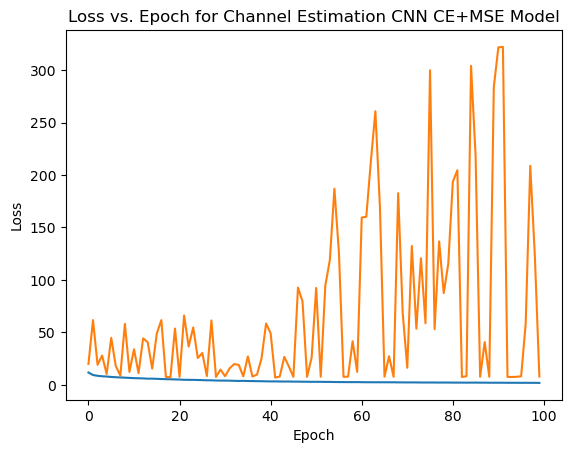

In [13]:
((loss_train_means, loss_train_ce_means, loss_train_mse_means), (loss_test_means, loss_test_ce_means, loss_test_mse_means)) \
    = results_map_chanest_cnn_ce_mse[min_loss_test_params]

plt.plot(loss_train_means)
plt.plot(loss_test_means)
plt.title('Loss vs. Epoch for Channel Estimation CNN CE+MSE Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [14]:
dataset_test_cnn_ce_mse = ChannelEstimationDatasetCNNCEMSE(otfs_data, test_indices)
test_loader_cnn_ce_mse = DataLoader(dataset_test_cnn_ce_mse, batch_size = BATCH_SIZE)

model = ChannelEstimationNetworkCNNCEMSE(dropout_rate = min_loss_test_params[2])
model.load_state_dict(torch.load('../model_weights/chanest_cnn_ce_mse_{}_{}_{}_0.0_0.0.pth'.format(*min_loss_test_params)))

<All keys matched successfully>

In [15]:
count_trainable_parameters(model)

67139240

In [25]:
model.eval()
y_numPaths_all = []
y_hat_numPaths_all = []
with torch.no_grad():
    for batch in tqdm(test_loader_cnn_ce_mse):
        X, y = batch
        y_numPaths = y[0]
        y_hat = model(X)
        y_hat_numPaths = np.argmax(y_hat[0], axis = 1)
        y_numPaths_all += y_numPaths.tolist()
        y_hat_numPaths_all += y_hat_numPaths.tolist()

y_numPaths_all = np.array(y_numPaths_all)
y_hat_numPaths_all = np.array(y_hat_numPaths_all)

100%|██████████| 63/63 [01:18<00:00,  1.25s/it]


In [26]:
(y_numPaths_all == y_hat_numPaths_all).mean(), (np.abs(y_numPaths_all - y_hat_numPaths_all) <= 1).mean()

(0.8095, 0.993)

In [11]:
def train_model_ce_mse(train_loader, test_loader, epochs = 50, lr = 1e-4, optimizer_name = 'adam',
                       dropout_rate = 0.0, l1_weight = 0.0, l2_weight = 0.0, verbose = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if verbose:
        print('Device =', device)

    model = ChannelEstimationNetworkCEMSE(dropout_rate)
    model.to(device)

    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    else:
        print('Optimizer not recognized:', optimizer_name)
        return None, None, None

    loss_fn_ce = nn.CrossEntropyLoss()
    loss_fn_mse = nn.MSELoss()

    loss_train_means = []
    loss_train_ce_means = []
    loss_train_mse_means = []
    loss_test_means = []
    loss_test_ce_means = []
    loss_test_mse_means = []

    min_test_loss = float('inf')

    for epoch in range(epochs):
        if verbose:
            print('Epoch', epoch + 1)

        loss_train = []
        loss_train_ce = []
        loss_train_mse = []
        loss_test = []
        loss_test_ce = []
        loss_test_mse = []

        model.train()
        for batch in tqdm(train_loader, disable = not verbose):
            X, (Y_paths, Y_channel) = batch
            X = X.to(device)
            Y_paths = Y_paths.to(device)
            Y_channel = Y_channel.to(device)
            
            Y_hat_paths, Y_hat_channel = model(X)
            loss_ce = loss_fn_ce(Y_hat_paths, Y_paths)
            loss_mse = loss_fn_mse(Y_hat_channel, Y_channel)
            loss_train_ce.append(loss_ce.item())
            loss_train_mse.append(loss_mse.item())
            
            loss = loss_ce + loss_mse

            # Compute L1 and L2 loss component
            # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md
            parameters = []
            for parameter in model.parameters():
                parameters.append(parameter.view(-1))
            l1 = l1_weight * model.compute_l1_loss(torch.cat(parameters))
            l2 = l2_weight * model.compute_l2_loss(torch.cat(parameters))

            loss = loss + l1 + l2
            
            loss_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Don't calculate gradients for test set
        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader, disable = not verbose):
                X, (Y_paths, Y_channel) = batch
                X = X.to(device)
                Y_paths = Y_paths.to(device)
                Y_channel = Y_channel.to(device)
                
                Y_hat_paths, Y_hat_channel = model(X)
                
                loss_ce = loss_fn_ce(Y_hat_paths, Y_paths)
                loss_mse = loss_fn_mse(Y_hat_channel, Y_channel)
                loss_test_ce.append(loss_ce.item())
                loss_test_mse.append(loss_mse.item())
                
                loss = loss_ce + loss_mse
                loss_test.append(loss.item())

        loss_train_mean = np.mean(loss_train)
        loss_test_mean = np.mean(loss_test)

        loss_train_means.append(loss_train_mean)
        loss_train_ce_means.append(np.mean(loss_train_ce))
        loss_train_mse_means.append(np.mean(loss_train_mse))
        loss_test_means.append(loss_test_mean)
        loss_test_ce_means.append(np.mean(loss_test_ce))
        loss_test_mse_means.append(np.mean(loss_test_mse))

        if verbose:
            print('Train Loss =', loss_train_mean)
            print('Train CE Loss =', np.mean(loss_train_ce))
            print('Train MSE Loss =', np.mean(loss_train_mse))
            print('Test Loss =', loss_test_mean)
            print('Test CE Loss =', np.mean(loss_test_ce))
            print('Test MSE Loss =', np.mean(loss_test_mse))
            
        if loss_test_mean < min_test_loss:
            min_test_loss = loss_test_mean
            if verbose:
                print('New min test loss =', min_test_loss)
            s = 'model_weights/chanest_mse_{}_{}_{}_{}_{}.pth'.format(lr, optimizer_name, dropout_rate, l1_weight, l2_weight)
            torch.save(model.state_dict(), s)

        if verbose:
            print('-' * 80)

    return model, (loss_train_means, loss_train_ce_means, loss_train_mse_means), (loss_test_means, loss_test_ce_means, loss_test_mse_means)

In [12]:
def train_model_mse(train_loader, test_loader, epochs = 50, lr = 1e-4, optimizer_name = 'adam',
                    dropout_rate = 0.0, l1_weight = 0.0, l2_weight = 0.0, verbose = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if verbose:
        print('Device =', device)

    model = ChannelEstimationNetworkMSE(dropout_rate)
    model.to(device)

    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    else:
        print('Optimizer not recognized:', optimizer_name)
        return None, None, None

    loss_fn_mse = nn.MSELoss()

    loss_train_means = []
    loss_test_means = []

    min_test_loss = float('inf')

    for epoch in range(epochs):
        if verbose:
            print('Epoch', epoch + 1)

        loss_train = []
        loss_test = []

        model.train()
        for batch in tqdm(train_loader, disable = not verbose):
            X, Y = batch
            X = X.to(device)
            Y = Y.to(device)
            
            Y_hat = model(X)
            loss = loss_fn_mse(Y_hat, Y)
              
            # Compute L1 and L2 loss component
            # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md
            parameters = []
            for parameter in model.parameters():
                parameters.append(parameter.view(-1))
            l1 = l1_weight * model.compute_l1_loss(torch.cat(parameters))
            l2 = l2_weight * model.compute_l2_loss(torch.cat(parameters))

            loss = loss + l1 + l2
            
            loss_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Don't calculate gradients for test set
        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader, disable = not verbose):
                X, Y = batch
                X = X.to(device)
                Y = Y.to(device)
                
                Y_hat = model(X)
                
                loss = loss_fn_mse(Y_hat, Y)
                loss_test.append(loss.item())

        loss_train_mean = np.mean(loss_train)
        loss_test_mean = np.mean(loss_test)
        
        loss_train_means.append(loss_train_mean)
        loss_test_means.append(loss_test_mean)

        if verbose:
            print('Train Loss =', loss_train_mean)
            print('Test Loss =', loss_test_mean)

        if loss_test_mean < min_test_loss:
            min_test_loss = loss_test_mean
            if verbose:
                print('New min test loss =', min_test_loss)
            s = 'model_weights/chanest_mse_{}_{}_{}_{}_{}.pth'.format(lr, optimizer_name, dropout_rate, l1_weight, l2_weight)
            torch.save(model.state_dict(), s)

        if verbose:
            print('-' * 80)

    return model, loss_train_means, loss_test_means

In [13]:
def train_model_cnn_mse(train_loader, test_loader, epochs = 50, lr = 1e-4, optimizer_name = 'adam',
                    dropout_rate = 0.0, l1_weight = 0.0, l2_weight = 0.0, verbose = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if verbose:
        print('Device =', device)

    model = ChannelEstimationNetworkCNNMSE(dropout_rate)
    model.to(device)

    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
    else:
        print('Optimizer not recognized:', optimizer_name)
        return None, None, None

    loss_fn_mse = nn.MSELoss()

    loss_train_means = []
    loss_test_means = []

    min_test_loss = float('inf')

    for epoch in range(epochs):
        if verbose:
            print('Epoch', epoch + 1)

        loss_train = []
        loss_test = []

        model.train()
        for batch in tqdm(train_loader, disable = not verbose):
            X, Y = batch
            X = X.to(device)
            Y = Y.to(device)
            
            Y_hat = model(X)
            loss = loss_fn_mse(Y_hat, Y)
              
            # Compute L1 and L2 loss component
            # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md
            parameters = []
            for parameter in model.parameters():
                parameters.append(parameter.view(-1))
            l1 = l1_weight * model.compute_l1_loss(torch.cat(parameters))
            l2 = l2_weight * model.compute_l2_loss(torch.cat(parameters))

            loss = loss + l1 + l2
            
            loss_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Don't calculate gradients for test set
        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader, disable = not verbose):
                X, Y = batch
                X = X.to(device)
                Y = Y.to(device)
                
                Y_hat = model(X)
                
                loss = loss_fn_mse(Y_hat, Y)
                loss_test.append(loss.item())

        loss_train_mean = np.mean(loss_train)
        loss_test_mean = np.mean(loss_test)
        
        loss_train_means.append(loss_train_mean)
        loss_test_means.append(loss_test_mean)

        if verbose:
            print('Train Loss =', loss_train_mean)
            print('Test Loss =', loss_test_mean)

        if loss_test_mean < min_test_loss:
            min_test_loss = loss_test_mean
            if verbose:
                print('New min test loss =', min_test_loss)
            s = 'model_weights/chanest_mse_{}_{}_{}_{}_{}.pth'.format(lr, optimizer_name, dropout_rate, l1_weight, l2_weight)
            torch.save(model.state_dict(), s)

        if verbose:
            print('-' * 80)

    return model, loss_train_means, loss_test_means

In [11]:
lrs = [1e-3, 1e-4, 1e-5]
optimizer_names = ['adam', 'rmsprop', 'adagrad']
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
l1_weights = [0.0, 1e-3, 1e-4, 1e-5]
l2_weights = [0.0, 1e-3, 1e-4, 1e-5]

In [6]:
script_head = '''#!/bin/bash
#SBATCH --job-name=ChannelEstimation_{0}_{1}
#SBATCH --mail-type=ALL
#SBATCH --mail-user=jturley1@umbc.edu
#SBATCH --mem=32000
#SBATCH --gres=gpu:1
#SBATCH --time=24:00:00
#SBATCH --error=ChannelEstimation_{0}_{1}.err
#SBATCH --output=ChannelEstimation_{0}_{1}.out

module load Anaconda3/2024.02-1
eval "$(conda shell.bash hook)"

conda activate 675
'''

In [7]:
for l1_weight in l1_weights:
    for l2_weight in l2_weights:
        s = script_head.format(l1_weight, l2_weight)

        for lr in lrs:
            for optimizer_name in optimizer_names:
                for dropout_rate in dropout_rates:
                    s += 'python ~/gokhale_user/675/project/python_scripts/ChannelEstimationCEMSEIndividual.py {0} {1} {2} {3} {4}\n'.format(
                        lr, optimizer_name, dropout_rate, l1_weight, l2_weight)

        f = open('/home/jturley1/gokhale_user/675/project/shell_scripts/ChannelEstimation/ChannelEstimationCEMSE_{}_{}.sh'.format(l1_weight, l2_weight), 'w')
        f.write(s)
        f.close()

In [8]:
for l1_weight in l1_weights:
    for l2_weight in l2_weights:
        s = script_head.format(l1_weight, l2_weight)

        for lr in lrs:
            for optimizer_name in optimizer_names:
                for dropout_rate in dropout_rates:
                    s += 'python ~/gokhale_user/675/project/python_scripts/ChannelEstimationMSEIndividual.py {0} {1} {2} {3} {4}\n'.format(
                        lr, optimizer_name, dropout_rate, l1_weight, l2_weight)

        f = open('/home/jturley1/gokhale_user/675/project/shell_scripts/ChannelEstimation/ChannelEstimationMSE_{}_{}.sh'.format(l1_weight, l2_weight), 'w')
        f.write(s)
        f.close()

In [12]:
!ls

ChannelEstimation.ipynb				EDA.ipynb
ChannelEstimationSymbolDemodulationJoint.ipynb	SymbolDemodulation.ipynb


In [117]:
# Combine output pkl files into single dict
results_map_ce_mse = {}
g = glob.glob('../results_maps/results_map_chanest_ce_mse_*')
for t in tqdm(g):
    f = open(t, 'rb')
    r = pkl.load(f)
    f.close()
    for key, val in r.items():
        results_map_ce_mse[key] = val

100%|██████████| 864/864 [00:15<00:00, 55.10it/s]


In [118]:
min_loss_test = float('inf')
min_loss_test_params = None
min_loss_test_epoch = None
for p, ( (loss_train_means, loss_train_ce_means, loss_train_mse_means), (loss_test_means, loss_test_ce_means, loss_test_mse_means)) \
    in results_map_ce_mse.items():
        loss_test_mean_min = np.min(loss_test_means)
        loss_test_mean_min_epoch = np.argmin(loss_test_means) + 1
        if loss_test_mean_min < min_loss_test:
            min_loss_test = loss_test_mean_min
            min_loss_test_params = p
            min_loss_test_epoch = loss_test_mean_min_epoch
min_loss_test, min_loss_test_params, min_loss_test_epoch

(np.float64(8.2168140809427), (0.001, 'adam', 0.1, 0.0, 0.0001), np.int64(12))

In [119]:
(loss_train_means, loss_train_ce_means, loss_train_mse_means), (loss_test_means, loss_test_ce_means, loss_test_mse_means) = \
    results_map_ce_mse[min_loss_test_params]

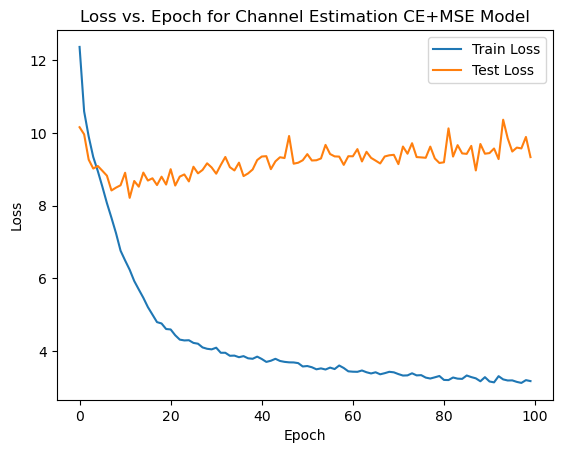

In [120]:
plt.plot(range(len(loss_train_means)), loss_train_means, label = 'Train Loss')
plt.plot(range(len(loss_test_means)), loss_test_means, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch for Channel Estimation CE+MSE Model')
plt.legend()

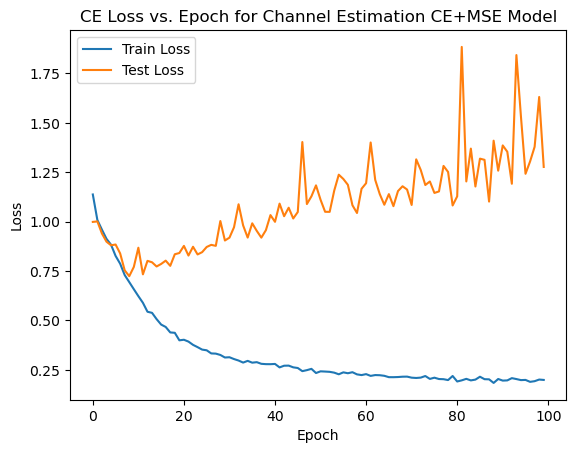

In [121]:
plt.plot(range(len(loss_train_ce_means)), loss_train_ce_means, label = 'Train Loss')
plt.plot(range(len(loss_test_ce_means)), loss_test_ce_means, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CE Loss vs. Epoch for Channel Estimation CE+MSE Model')
plt.legend()

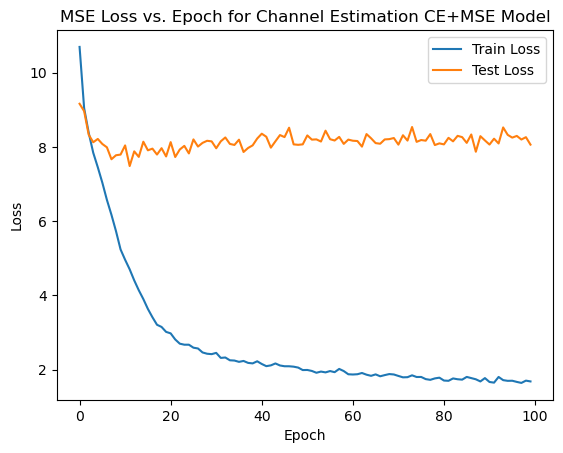

In [122]:
plt.plot(range(len(loss_train_mse_means)), loss_train_mse_means, label = 'Train Loss')
plt.plot(range(len(loss_test_mse_means)), loss_test_mse_means, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss vs. Epoch for Channel Estimation CE+MSE Model')
plt.legend()

In [123]:
# Load model
p = '../model_weights/chanest_ce_mse_{}_{}_{}_*'.format(*min_loss_test_params)
g = glob.glob(p)
model_path = g[0]
model_path

'../model_weights/chanest_ce_mse_0.001_adam_0.1_0.001_0.0001.pth'

In [124]:
model = ChannelEstimationNetworkCEMSE(min_loss_test_params[2])
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [125]:
count_trainable_parameters(model)

11862292

In [69]:
dataset_test_ce_mse = ChannelEstimationDatasetCEMSE(otfs_data, test_indices)
test_loader_ce_mse = DataLoader(dataset_test_ce_mse, batch_size = BATCH_SIZE)

model.eval()
y_numPaths_all = []
y_hat_numPaths_all = []
with torch.no_grad():
    for batch in tqdm(test_loader_ce_mse):
        X, y = batch
        y_numPaths = y[0]
        y_hat = model(X)
        y_hat_numPaths = np.argmax(y_hat[0], axis = 1)
        y_numPaths_all += y_numPaths.tolist()
        y_hat_numPaths_all += y_hat_numPaths.tolist()

y_numPaths_all = np.array(y_numPaths_all)
y_hat_numPaths_all = np.array(y_hat_numPaths_all)

100%|██████████| 63/63 [00:01<00:00, 55.21it/s]


In [70]:
(y_numPaths_all == y_hat_numPaths_all).mean()

np.float64(0.635)

In [74]:
(np.abs(y_numPaths_all - y_hat_numPaths_all) <= 1).mean()

np.float64(0.947)

In [71]:
((y_numPaths_all - y_hat_numPaths_all)**2).mean()

np.float64(0.5465)

In [126]:
# Combine output pkl files into single dict
results_map_mse = {}
g = glob.glob('../results_maps/results_map_chanest_mse_*')
for t in tqdm(g):
    f = open(t, 'rb')
    r = pkl.load(f)
    f.close()
    for key, val in r.items():
        results_map_mse[key] = val

100%|██████████| 864/864 [00:01<00:00, 732.69it/s]


In [127]:
min_loss_test = float('inf')
min_loss_test_params = None
min_loss_test_epoch = None
for p, (loss_train_means, loss_test_means) in results_map_mse.items():
        loss_test_mean_min = np.min(loss_test_means)
        loss_test_mean_min_epoch = np.argmin(loss_test_means) + 1
        if loss_test_mean_min < min_loss_test:
            min_loss_test = loss_test_mean_min
            min_loss_test_params = p
            min_loss_test_epoch = loss_test_mean_min_epoch
min_loss_test, min_loss_test_params, min_loss_test_epoch

(np.float64(7.134861663901381),
 (0.001, 'rmsprop', 0.3, 0.0, 1e-05),
 np.int64(61))

In [128]:
loss_train_means, loss_test_means = results_map_mse[min_loss_test_params]

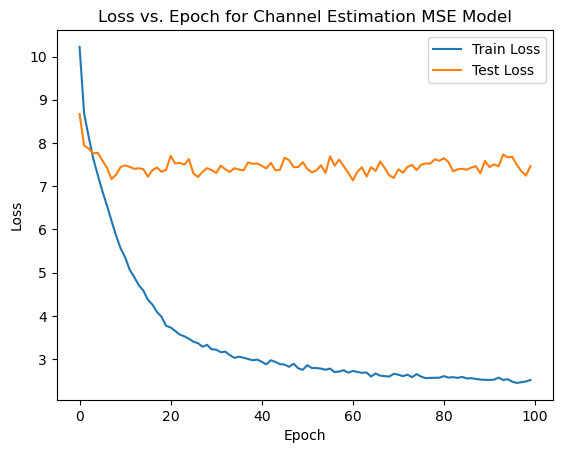

In [129]:
plt.plot(range(len(loss_train_means)), loss_train_means, label = 'Train Loss')
plt.plot(range(len(loss_test_means)), loss_test_means, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch for Channel Estimation MSE Model')
plt.legend()

In [130]:
# Load model
p = '../model_weights/chanest_mse_{}_{}_{}_*'.format(*min_loss_test_params)
g = glob.glob(p)
model_path = g[0]
model_path

'../model_weights/chanest_mse_0.001_rmsprop_0.3_0.0001_0.0.pth'

In [131]:
model = ChannelEstimationNetworkMSE(min_loss_test_params[2])
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [132]:
count_trainable_parameters(model)

11861264

In [108]:
dataset_test_mse = ChannelEstimationDatasetMSE(otfs_data, test_indices)
test_loader_mse = DataLoader(dataset_test_mse, batch_size = BATCH_SIZE)

model.eval()
y_numPaths_all = []
y_hat_numPaths_all = []
with torch.no_grad():
    for batch in tqdm(test_loader_mse):
        X, y = batch
        y_numPaths = y[:, 0]
        y_hat = model(X)
        y_hat_numPaths = y_hat[:, 0]
        y_numPaths_all += y_numPaths.tolist()
        y_hat_numPaths_all += y_hat_numPaths.tolist()

y_numPaths_all = np.array(y_numPaths_all)
y_hat_numPaths_all = np.array(y_hat_numPaths_all)
y_hat_numPaths_all_r = y_hat_numPaths_all.round()

100%|██████████| 63/63 [00:01<00:00, 60.12it/s]


In [109]:
(y_numPaths_all == y_hat_numPaths_all_r).mean()

np.float64(0.2865)

In [111]:
(np.abs(y_numPaths_all - y_hat_numPaths_all_r) <= 1).mean()

np.float64(0.685)

In [112]:
((y_numPaths_all - y_hat_numPaths_all)**2).mean()

np.float64(1.9943270081227769)

In [113]:
((y_numPaths_all - y_hat_numPaths_all_r)**2).mean()

np.float64(2.0185)

In [19]:
try:
    f = open('../results_maps/results_map_ce_mse.pkl.old', 'rb')
    results_map_ce_mse = pkl.load(f)
    f.close()
except:
    results_map_ce_mse = {}

In [20]:
results_map_ce_mse.keys()

dict_keys([(0.001, 'adam', 0.0), (0.001, 'adam', 0.1), (0.001, 'adam', 0.2), (0.001, 'adam', 0.3), (0.001, 'adam', 0.4), (0.001, 'adam', 0.5), (0.001, 'rmsprop', 0.0), (0.001, 'rmsprop', 0.1), (0.001, 'rmsprop', 0.2), (0.001, 'rmsprop', 0.3), (0.001, 'rmsprop', 0.4), (0.001, 'rmsprop', 0.5), (0.001, 'adagrad', 0.0), (0.001, 'adagrad', 0.1), (0.001, 'adagrad', 0.2), (0.001, 'adagrad', 0.3), (0.001, 'adagrad', 0.4), (0.001, 'adagrad', 0.5), (0.0001, 'adam', 0.0), (0.0001, 'adam', 0.1), (0.0001, 'adam', 0.2), (0.0001, 'adam', 0.3), (0.0001, 'adam', 0.4), (0.0001, 'adam', 0.5), (0.0001, 'rmsprop', 0.0), (0.0001, 'rmsprop', 0.1), (0.0001, 'rmsprop', 0.2), (0.0001, 'rmsprop', 0.3), (0.0001, 'rmsprop', 0.4), (0.0001, 'rmsprop', 0.5), (0.0001, 'adagrad', 0.0), (0.0001, 'adagrad', 0.1), (0.0001, 'adagrad', 0.2), (0.0001, 'adagrad', 0.3), (0.0001, 'adagrad', 0.4), (0.0001, 'adagrad', 0.5), (1e-05, 'adam', 0.0), (1e-05, 'adam', 0.1), (1e-05, 'adam', 0.2), (1e-05, 'adam', 0.3), (1e-05, 'adam', 0.4

In [19]:
for lr in lrs:
    for optimizer_name in optimizer_names:
        for dropout_rate in dropout_rates:
            for l1_weight in l1_weights:
                for l2_weight in l2_weights:
                    dataset_train_ce_mse = ChannelEstimationDatasetCEMSE(otfs_data, train_indices)
                    train_loader_ce_mse = DataLoader(dataset_train_ce_mse, batch_size = BATCH_SIZE, shuffle=True)
                    
                    dataset_test_ce_mse = ChannelEstimationDatasetCEMSE(otfs_data, test_indices)
                    test_loader_ce_mse = DataLoader(dataset_test_ce_mse, batch_size = BATCH_SIZE)
        
                    k = (lr, optimizer_name, dropout_rate, l1_weight, l2_weight)
                    print(k)
                    if k in results_map_ce_mse:
                        print(k, 'already trained, skipping')
                        continue
                    results_map_ce_mse[k] = train_model_ce_mse(train_loader_ce_mse, test_loader_ce_mse, epochs = EPOCHS, lr = lr,
                                                               optimizer_name = optimizer_name, dropout_rate = dropout_rate,
                                                               l1_weight = l1_weight, l2_weight = l2_weight, verbose = True)

(0.001, 'adam', 0.0, 0, 0)
Device = cuda
Epoch 1


100%|██████████| 63/63 [00:00<00:00, 224.48it/s]


Train Loss = 11.621960852552517
Train CE Loss = 1.1198972025157723
Train MSE Loss = 10.502063650036744
Test Loss = 10.213820423066416
Test CE Loss = 1.009210706050215
Test MSE Loss = 9.204609717016202
New min test loss = 10.213820423066416
--------------------------------------------------------------------------------
Epoch 2


100%|██████████| 63/63 [00:00<00:00, 224.81it/s]


Train Loss = 9.852495880340241
Train CE Loss = 0.9848694212483177
Train MSE Loss = 8.867626459091921
Test Loss = 9.461073471420944
Test CE Loss = 0.9263157925576881
Test MSE Loss = 8.534757678863256
New min test loss = 9.461073471420944
--------------------------------------------------------------------------------
Epoch 3


100%|██████████| 63/63 [00:00<00:00, 223.70it/s]


Train Loss = 9.045225458079207
Train CE Loss = 0.9166083153972097
Train MSE Loss = 8.128617142681996
Test Loss = 9.359418448373619
Test CE Loss = 0.9286971719530788
Test MSE Loss = 8.430721276420538
New min test loss = 9.359418448373619
--------------------------------------------------------------------------------
Epoch 4


100%|██████████| 63/63 [00:00<00:00, 222.62it/s]


Train Loss = 8.418704781287593
Train CE Loss = 0.8656215939572692
Train MSE Loss = 7.553083187330326
Test Loss = 8.734768559495073
Test CE Loss = 0.8508585383255692
Test MSE Loss = 7.8839100211695055
New min test loss = 8.734768559495073
--------------------------------------------------------------------------------
Epoch 5


100%|██████████| 63/63 [00:00<00:00, 224.43it/s]


Train Loss = 7.917030496685431
Train CE Loss = 0.8130593273347613
Train MSE Loss = 7.10397116935067
Test Loss = 8.930294750326999
Test CE Loss = 0.9218866467215839
Test MSE Loss = 8.008408103605415
--------------------------------------------------------------------------------
Epoch 6


100%|██████████| 63/63 [00:00<00:00, 220.92it/s]


Train Loss = 7.269981388365057
Train CE Loss = 0.7658594338657381
Train MSE Loss = 6.504121954499318
Test Loss = 8.924145214629398
Test CE Loss = 0.8704925510153279
Test MSE Loss = 8.053652663614068
--------------------------------------------------------------------------------
Epoch 7


100%|██████████| 63/63 [00:00<00:00, 221.96it/s]


Train Loss = 6.620220127777726
Train CE Loss = 0.6939474261578252
Train MSE Loss = 5.926272701619901
Test Loss = 8.732802613112842
Test CE Loss = 0.7903194221943862
Test MSE Loss = 7.942483190918455
New min test loss = 8.732802613112842
--------------------------------------------------------------------------------
Epoch 8


100%|██████████| 63/63 [00:00<00:00, 221.94it/s]


Train Loss = 5.8929326406902325
Train CE Loss = 0.6363496455494346
Train MSE Loss = 5.256582995140799
Test Loss = 8.62964649599765
Test CE Loss = 0.747079874116648
Test MSE Loss = 7.8825666218810015
New min test loss = 8.62964649599765
--------------------------------------------------------------------------------
Epoch 9


100%|██████████| 63/63 [00:00<00:00, 222.86it/s]


Train Loss = 5.350760806980795
Train CE Loss = 0.5818534286671928
Train MSE Loss = 4.768907378313603
Test Loss = 8.782437056216802
Test CE Loss = 0.7290092410309319
Test MSE Loss = 8.053427815185872
--------------------------------------------------------------------------------
Epoch 10


100%|██████████| 63/63 [00:00<00:00, 223.79it/s]


Train Loss = 4.811542467654816
Train CE Loss = 0.5105042481335399
Train MSE Loss = 4.301038219521276
Test Loss = 8.7200489171967
Test CE Loss = 0.7458597336094612
Test MSE Loss = 7.974189183587239
--------------------------------------------------------------------------------
Epoch 11


100%|██████████| 63/63 [00:00<00:00, 223.82it/s]


Train Loss = 4.318950109813683
Train CE Loss = 0.47998956702832163
Train MSE Loss = 3.8389605427853613
Test Loss = 8.690196510901696
Test CE Loss = 0.780214528478459
Test MSE Loss = 7.909981982423238
--------------------------------------------------------------------------------
Epoch 12


100%|██████████| 63/63 [00:00<00:00, 223.31it/s]


Train Loss = 3.847212824457843
Train CE Loss = 0.43976142489405906
Train MSE Loss = 3.4074513995637834
Test Loss = 8.546423535716958
Test CE Loss = 0.7515883334362714
Test MSE Loss = 7.794835202280686
New min test loss = 8.546423535716958
--------------------------------------------------------------------------------
Epoch 13


100%|██████████| 63/63 [00:00<00:00, 223.94it/s]


Train Loss = 3.438729629864385
Train CE Loss = 0.4048537161481924
Train MSE Loss = 3.033875913716193
Test Loss = 8.787455583009628
Test CE Loss = 0.8284722123194612
Test MSE Loss = 7.9589833706901665
--------------------------------------------------------------------------------
Epoch 14


100%|██████████| 63/63 [00:00<00:00, 223.96it/s]


Train Loss = 3.104643351581057
Train CE Loss = 0.36948891458966776
Train MSE Loss = 2.7351544369913885
Test Loss = 9.159209064451332
Test CE Loss = 0.8439298076809483
Test MSE Loss = 8.315279256770383
--------------------------------------------------------------------------------
Epoch 15


100%|██████████| 63/63 [00:00<00:00, 224.12it/s]


Train Loss = 2.77849567815697
Train CE Loss = 0.3299263476347678
Train MSE Loss = 2.448569330522202
Test Loss = 8.904854850674964
Test CE Loss = 0.8594783254843961
Test MSE Loss = 8.045376525190568
--------------------------------------------------------------------------------
Epoch 16


100%|██████████| 63/63 [00:00<00:00, 222.92it/s]


Train Loss = 2.5515154497981682
Train CE Loss = 0.2936338165183745
Train MSE Loss = 2.257881633279794
Test Loss = 8.96206795711667
Test CE Loss = 0.9102037379930096
Test MSE Loss = 8.051864219123658
--------------------------------------------------------------------------------
Epoch 17


100%|██████████| 63/63 [00:00<00:00, 223.08it/s]


Train Loss = 2.3780279266937487
Train CE Loss = 0.2817827867874617
Train MSE Loss = 2.096245139906287
Test Loss = 8.866319364984669
Test CE Loss = 0.8845784713343017
Test MSE Loss = 7.98174089365037
--------------------------------------------------------------------------------
Epoch 18


100%|██████████| 63/63 [00:00<00:00, 223.04it/s]


Train Loss = 2.225067191550488
Train CE Loss = 0.25697935288527723
Train MSE Loss = 1.9680878386652112
Test Loss = 9.068240408008574
Test CE Loss = 0.9214795285408437
Test MSE Loss = 8.14676087946773
--------------------------------------------------------------------------------
Epoch 19


100%|██████████| 63/63 [00:00<00:00, 222.34it/s]


Train Loss = 2.083749036825938
Train CE Loss = 0.2345602974673492
Train MSE Loss = 1.8491887393585884
Test Loss = 8.851637348118675
Test CE Loss = 0.9791184447739817
Test MSE Loss = 7.872518903344696
--------------------------------------------------------------------------------
Epoch 20


100%|██████████| 63/63 [00:00<00:00, 223.08it/s]


Train Loss = 1.973504118455169
Train CE Loss = 0.21230428019314718
Train MSE Loss = 1.7611998382620218
Test Loss = 9.48535886389009
Test CE Loss = 1.2013473712719307
Test MSE Loss = 8.28401149261816
--------------------------------------------------------------------------------
Epoch 21


100%|██████████| 63/63 [00:00<00:00, 222.74it/s]


Train Loss = 1.915553169105611
Train CE Loss = 0.20473530056061215
Train MSE Loss = 1.7108178685449988
Test Loss = 9.619329687668339
Test CE Loss = 1.0279656629623353
Test MSE Loss = 8.591364024706003
--------------------------------------------------------------------------------
Epoch 22


100%|██████████| 63/63 [00:00<00:00, 223.00it/s]


Train Loss = 1.7432229619228736
Train CE Loss = 0.18974196326873455
Train MSE Loss = 1.553480998654139
Test Loss = 9.03004313782031
Test CE Loss = 1.0444932790179167
Test MSE Loss = 7.9855498588023925
--------------------------------------------------------------------------------
Epoch 23


100%|██████████| 63/63 [00:00<00:00, 222.65it/s]


Train Loss = 1.6455612821008574
Train CE Loss = 0.18446115016299575
Train MSE Loss = 1.4611001319378616
Test Loss = 9.012366927244075
Test CE Loss = 0.9996787267719041
Test MSE Loss = 8.012688200472171
--------------------------------------------------------------------------------
Epoch 24


100%|██████████| 63/63 [00:00<00:00, 223.13it/s]


Train Loss = 1.5453092458088877
Train CE Loss = 0.16524487495345402
Train MSE Loss = 1.3800643708554339
Test Loss = 8.774140823946075
Test CE Loss = 0.9830616875753073
Test MSE Loss = 7.791079136370768
--------------------------------------------------------------------------------
Epoch 25


100%|██████████| 63/63 [00:00<00:00, 222.35it/s]


Train Loss = 1.563811939140833
Train CE Loss = 0.15903020028420303
Train MSE Loss = 1.40478173885663
Test Loss = 9.165733035582422
Test CE Loss = 1.0374364120309805
Test MSE Loss = 8.128296623551446
--------------------------------------------------------------------------------
Epoch 26


100%|██████████| 63/63 [00:00<00:00, 222.90it/s]


Train Loss = 1.4105793863045155
Train CE Loss = 0.14051250846837907
Train MSE Loss = 1.2700668778361364
Test Loss = 9.424612805484118
Test CE Loss = 1.0962970379963515
Test MSE Loss = 8.32831576748777
--------------------------------------------------------------------------------
Epoch 27


100%|██████████| 63/63 [00:00<00:00, 221.38it/s]


Train Loss = 1.4642295789923094
Train CE Loss = 0.15790271527485233
Train MSE Loss = 1.306326863717457
Test Loss = 9.251185545263287
Test CE Loss = 1.0416699058269059
Test MSE Loss = 8.209515639436377
--------------------------------------------------------------------------------
Epoch 28


100%|██████████| 63/63 [00:00<00:00, 221.27it/s]


Train Loss = 1.3666174516384457
Train CE Loss = 0.12818375021345202
Train MSE Loss = 1.2384337014249935
Test Loss = 9.138818906342017
Test CE Loss = 1.191305645567283
Test MSE Loss = 7.947513260774733
--------------------------------------------------------------------------------
Epoch 29


100%|██████████| 63/63 [00:00<00:00, 221.25it/s]


Train Loss = 1.370123406788806
Train CE Loss = 0.13663669427521696
Train MSE Loss = 1.233486712513589
Test Loss = 9.06935593738483
Test CE Loss = 1.0349578082669109
Test MSE Loss = 8.034398129117918
--------------------------------------------------------------------------------
Epoch 30


100%|██████████| 63/63 [00:00<00:00, 220.65it/s]


Train Loss = 1.4251273362604302
Train CE Loss = 0.14561182248009846
Train MSE Loss = 1.2795155137803318
Test Loss = 9.006504004798742
Test CE Loss = 0.99794931289614
Test MSE Loss = 8.008554691902598
--------------------------------------------------------------------------------
Epoch 31


100%|██████████| 63/63 [00:00<00:00, 220.97it/s]


Train Loss = 1.2628259232473489
Train CE Loss = 0.11711686000688899
Train MSE Loss = 1.1457090632404596
Test Loss = 9.29608761811825
Test CE Loss = 1.1630081098867953
Test MSE Loss = 8.133079508231457
--------------------------------------------------------------------------------
Epoch 32


100%|██████████| 63/63 [00:00<00:00, 221.12it/s]


Train Loss = 1.1733318973894737
Train CE Loss = 0.10444940349442705
Train MSE Loss = 1.0688824938950465
Test Loss = 9.527463424729975
Test CE Loss = 1.1404184924348038
Test MSE Loss = 8.38704493229517
--------------------------------------------------------------------------------
Epoch 33


100%|██████████| 63/63 [00:00<00:00, 221.18it/s]


Train Loss = 1.1957345039988831
Train CE Loss = 0.10828648992951166
Train MSE Loss = 1.0874480140693714
Test Loss = 9.257797133011657
Test CE Loss = 1.1246216212824305
Test MSE Loss = 8.133175511729226
--------------------------------------------------------------------------------
Epoch 34


100%|██████████| 63/63 [00:00<00:00, 221.39it/s]


Train Loss = 1.2060304051095179
Train CE Loss = 0.11305539210460647
Train MSE Loss = 1.0929750130049114
Test Loss = 9.297030918826149
Test CE Loss = 1.1659961834349073
Test MSE Loss = 8.131034735391239
--------------------------------------------------------------------------------
Epoch 35


100%|██████████| 63/63 [00:00<00:00, 221.81it/s]


Train Loss = 1.1084142987887138
Train CE Loss = 0.09775354396412898
Train MSE Loss = 1.0106607548245847
Test Loss = 9.237517143815436
Test CE Loss = 1.1470231195086833
Test MSE Loss = 8.090494024306757
--------------------------------------------------------------------------------
Epoch 36


100%|██████████| 63/63 [00:00<00:00, 221.49it/s]


Train Loss = 1.1200826128215366
Train CE Loss = 0.09752981245769612
Train MSE Loss = 1.0225528003638404
Test Loss = 9.633153248906558
Test CE Loss = 1.2553258742384903
Test MSE Loss = 8.377827374668069
--------------------------------------------------------------------------------
Epoch 37


100%|██████████| 63/63 [00:00<00:00, 220.71it/s]


Train Loss = 1.0386273592079946
Train CE Loss = 0.09167588222388749
Train MSE Loss = 0.9469514769841073
Test Loss = 9.043976722542737
Test CE Loss = 1.2147969051328191
Test MSE Loss = 7.829179817409916
--------------------------------------------------------------------------------
Epoch 38


100%|██████████| 63/63 [00:00<00:00, 221.21it/s]


Train Loss = 1.0206530493347479
Train CE Loss = 0.09579603120371821
Train MSE Loss = 0.9248570181310295
Test Loss = 9.250869201225939
Test CE Loss = 1.2288120063895995
Test MSE Loss = 8.022057194836343
--------------------------------------------------------------------------------
Epoch 39


100%|██████████| 63/63 [00:00<00:00, 220.94it/s]


Train Loss = 0.97221481230249
Train CE Loss = 0.0761356741890084
Train MSE Loss = 0.8960791381134816
Test Loss = 9.480169798794217
Test CE Loss = 1.2309317782232296
Test MSE Loss = 8.249238020570985
--------------------------------------------------------------------------------
Epoch 40


100%|██████████| 63/63 [00:00<00:00, 221.65it/s]


Train Loss = 0.9902652686294129
Train CE Loss = 0.09341063456702167
Train MSE Loss = 0.8968546340623913
Test Loss = 9.353225785934896
Test CE Loss = 1.2060817850280554
Test MSE Loss = 8.147144000906836
--------------------------------------------------------------------------------
Epoch 41


100%|██████████| 63/63 [00:00<00:00, 221.12it/s]


Train Loss = 0.8881484777200933
Train CE Loss = 0.07580443721557732
Train MSE Loss = 0.812344040504516
Test Loss = 9.409775025257714
Test CE Loss = 1.2154331284786615
Test MSE Loss = 8.194341896779056
--------------------------------------------------------------------------------
Epoch 42


100%|██████████| 63/63 [00:00<00:00, 221.29it/s]


Train Loss = 0.974519296936678
Train CE Loss = 0.0859770152300895
Train MSE Loss = 0.8885422817065886
Test Loss = 9.210477904882499
Test CE Loss = 1.1233765066466441
Test MSE Loss = 8.087101398235852
--------------------------------------------------------------------------------
Epoch 43


100%|██████████| 63/63 [00:00<00:00, 221.55it/s]


Train Loss = 0.9289371945471329
Train CE Loss = 0.07799448883604611
Train MSE Loss = 0.8509427057110868
Test Loss = 9.452381131740713
Test CE Loss = 1.3467472923945594
Test MSE Loss = 8.105633839346153
--------------------------------------------------------------------------------
Epoch 44


100%|██████████| 63/63 [00:00<00:00, 221.25it/s]


Train Loss = 0.9416053335121778
Train CE Loss = 0.07866842652632598
Train MSE Loss = 0.8629369069858518
Test Loss = 9.279897953924497
Test CE Loss = 1.1770408635545526
Test MSE Loss = 8.102857090369941
--------------------------------------------------------------------------------
Epoch 45


100%|██████████| 63/63 [00:00<00:00, 220.83it/s]


Train Loss = 0.8572818740215625
Train CE Loss = 0.0675809900450867
Train MSE Loss = 0.7897008839764758
Test Loss = 9.601492959156255
Test CE Loss = 1.317890065369822
Test MSE Loss = 8.283602893786432
--------------------------------------------------------------------------------
Epoch 46


100%|██████████| 63/63 [00:00<00:00, 221.21it/s]


Train Loss = 0.8585358180559538
Train CE Loss = 0.06269549189349745
Train MSE Loss = 0.7958403261624563
Test Loss = 9.389426038257344
Test CE Loss = 1.1633265038433527
Test MSE Loss = 8.226099534413992
--------------------------------------------------------------------------------
Epoch 47


100%|██████████| 63/63 [00:00<00:00, 220.93it/s]


Train Loss = 0.8250151099768399
Train CE Loss = 0.06091333667170697
Train MSE Loss = 0.7641017733051328
Test Loss = 9.336851744962251
Test CE Loss = 1.215397487412555
Test MSE Loss = 8.121454257549694
--------------------------------------------------------------------------------
Epoch 48


100%|██████████| 63/63 [00:00<00:00, 220.66it/s]


Train Loss = 0.8069982493350363
Train CE Loss = 0.06280919567990959
Train MSE Loss = 0.7441890536551264
Test Loss = 9.542464943394771
Test CE Loss = 1.2167139046198652
Test MSE Loss = 8.325751038774905
--------------------------------------------------------------------------------
Epoch 49


100%|██████████| 63/63 [00:00<00:00, 220.99it/s]


Train Loss = 0.7482297774675224
Train CE Loss = 0.05748478717662604
Train MSE Loss = 0.6907449902908963
Test Loss = 9.211448991346549
Test CE Loss = 1.2729135456488039
Test MSE Loss = 7.938535445697747
--------------------------------------------------------------------------------
Epoch 50


100%|██████████| 63/63 [00:00<00:00, 221.41it/s]


Train Loss = 0.750514811916807
Train CE Loss = 0.06957868256756589
Train MSE Loss = 0.680936129349241
Test Loss = 9.300671938776206
Test CE Loss = 1.2226726571528292
Test MSE Loss = 8.077999281623377
--------------------------------------------------------------------------------
Epoch 51


100%|██████████| 63/63 [00:00<00:00, 221.23it/s]


Train Loss = 0.7496409471518941
Train CE Loss = 0.05755820830689305
Train MSE Loss = 0.6920827388450009
Test Loss = 9.51215337766832
Test CE Loss = 1.3447852512800682
Test MSE Loss = 8.16736812638825
--------------------------------------------------------------------------------
Epoch 52


100%|██████████| 63/63 [00:00<00:00, 220.70it/s]


Train Loss = 0.7245165275540153
Train CE Loss = 0.05601657737201738
Train MSE Loss = 0.6684999501819977
Test Loss = 9.456898232311591
Test CE Loss = 1.2897543508613059
Test MSE Loss = 8.167143881450288
--------------------------------------------------------------------------------
Epoch 53


100%|██████████| 63/63 [00:00<00:00, 221.32it/s]


Train Loss = 0.7593068031119039
Train CE Loss = 0.07284028188665796
Train MSE Loss = 0.686466521225246
Test Loss = 9.591615559581564
Test CE Loss = 1.2749594716208976
Test MSE Loss = 8.316656087960665
--------------------------------------------------------------------------------
Epoch 54


100%|██████████| 63/63 [00:00<00:00, 221.34it/s]


Train Loss = 0.7063210923943559
Train CE Loss = 0.059631025420417046
Train MSE Loss = 0.6466900669739389
Test Loss = 9.607919398748024
Test CE Loss = 1.3833439775355105
Test MSE Loss = 8.224575421212514
--------------------------------------------------------------------------------
Epoch 55


100%|██████████| 63/63 [00:00<00:00, 221.34it/s]


Train Loss = 0.6735723163088171
Train CE Loss = 0.04900889493580969
Train MSE Loss = 0.6245634213730072
Test Loss = 9.437036326839637
Test CE Loss = 1.355597259213563
Test MSE Loss = 8.081439067626073
--------------------------------------------------------------------------------
Epoch 56


100%|██████████| 63/63 [00:00<00:00, 221.50it/s]


Train Loss = 0.6050214060880037
Train CE Loss = 0.04725122912227566
Train MSE Loss = 0.5577701769657281
Test Loss = 9.394463487575855
Test CE Loss = 1.3395367547983676
Test MSE Loss = 8.054926732777487
--------------------------------------------------------------------------------
Epoch 57


100%|██████████| 63/63 [00:00<00:00, 221.60it/s]


Train Loss = 0.6453226846192014
Train CE Loss = 0.04555117810961833
Train MSE Loss = 0.599771506509583
Test Loss = 9.973229402899966
Test CE Loss = 1.4092541147793156
Test MSE Loss = 8.563975288120652
--------------------------------------------------------------------------------
Epoch 58


100%|██████████| 63/63 [00:00<00:00, 221.31it/s]


Train Loss = 0.7467384827691536
Train CE Loss = 0.0544100811709033
Train MSE Loss = 0.6923284015982502
Test Loss = 9.54671695819967
Test CE Loss = 1.4060963916983258
Test MSE Loss = 8.140620566501346
--------------------------------------------------------------------------------
Epoch 59


100%|██████████| 63/63 [00:00<00:00, 221.00it/s]


Train Loss = 0.6710386433037936
Train CE Loss = 0.05362938699617353
Train MSE Loss = 0.6174092563076202
Test Loss = 10.096157035173208
Test CE Loss = 1.4996471810420058
Test MSE Loss = 8.596509854131204
--------------------------------------------------------------------------------
Epoch 60


100%|██████████| 63/63 [00:00<00:00, 221.41it/s]


Train Loss = 0.7006320612598057
Train CE Loss = 0.0535587011445358
Train MSE Loss = 0.64707336011527
Test Loss = 9.488838119847566
Test CE Loss = 1.3774305372890614
Test MSE Loss = 8.111407582558506
--------------------------------------------------------------------------------
Epoch 61


100%|██████████| 63/63 [00:00<00:00, 221.25it/s]


Train Loss = 0.6670857111238557
Train CE Loss = 0.051505997678992894
Train MSE Loss = 0.6155797134448628
Test Loss = 9.40626297062703
Test CE Loss = 1.4582880155132938
Test MSE Loss = 7.947974955113734
--------------------------------------------------------------------------------
Epoch 62


100%|██████████| 63/63 [00:00<00:00, 221.18it/s]


Train Loss = 0.5699610566381326
Train CE Loss = 0.04373388053370003
Train MSE Loss = 0.5262271761044325
Test Loss = 9.438823291515423
Test CE Loss = 1.3685346860123957
Test MSE Loss = 8.070288605503025
--------------------------------------------------------------------------------
Epoch 63


100%|██████████| 63/63 [00:00<00:00, 221.10it/s]


Train Loss = 0.6231941341187385
Train CE Loss = 0.03646416724284803
Train MSE Loss = 0.5867299668758903
Test Loss = 9.405997088138506
Test CE Loss = 1.4308361766241289
Test MSE Loss = 7.975160911514377
--------------------------------------------------------------------------------
Epoch 64


100%|██████████| 63/63 [00:00<00:00, 220.98it/s]


Train Loss = 0.5795563709125064
Train CE Loss = 0.04232485702402672
Train MSE Loss = 0.5372315138884797
Test Loss = 9.550588804817119
Test CE Loss = 1.5941392188217225
Test MSE Loss = 7.956449585995396
--------------------------------------------------------------------------------
Epoch 65


 59%|█████▉    | 147/250 [00:02<00:01, 64.62it/s]


KeyboardInterrupt: 

In [15]:
f = open('results_map_chanest_ce_mse.pkl', 'wb')
pkl.dump(results_map_ce_mse, f)
f.close()

In [21]:
try:
    f = open('../results_maps/results_map_mse.pkl.old', 'rb')
    results_map_mse = pkl.load(f)
    f.close()
except:
    results_map_mse = {}

In [22]:
results_map_mse.keys()

dict_keys([(0.001, 'adam', 0.0), (0.001, 'adam', 0.1), (0.001, 'adam', 0.2), (0.001, 'adam', 0.3), (0.001, 'adam', 0.4), (0.001, 'adam', 0.5), (0.001, 'rmsprop', 0.0), (0.001, 'rmsprop', 0.1), (0.001, 'rmsprop', 0.2), (0.001, 'rmsprop', 0.3), (0.001, 'rmsprop', 0.4), (0.001, 'rmsprop', 0.5), (0.001, 'adagrad', 0.0), (0.001, 'adagrad', 0.1), (0.001, 'adagrad', 0.2), (0.001, 'adagrad', 0.3), (0.001, 'adagrad', 0.4), (0.001, 'adagrad', 0.5), (0.0001, 'adam', 0.0), (0.0001, 'adam', 0.1), (0.0001, 'adam', 0.2), (0.0001, 'adam', 0.3), (0.0001, 'adam', 0.4), (0.0001, 'adam', 0.5), (0.0001, 'rmsprop', 0.0), (0.0001, 'rmsprop', 0.1), (0.0001, 'rmsprop', 0.2), (0.0001, 'rmsprop', 0.3), (0.0001, 'rmsprop', 0.4), (0.0001, 'rmsprop', 0.5), (0.0001, 'adagrad', 0.0), (0.0001, 'adagrad', 0.1), (0.0001, 'adagrad', 0.2), (0.0001, 'adagrad', 0.3), (0.0001, 'adagrad', 0.4), (0.0001, 'adagrad', 0.5), (1e-05, 'adam', 0.0), (1e-05, 'adam', 0.1), (1e-05, 'adam', 0.2), (1e-05, 'adam', 0.3), (1e-05, 'adam', 0.4

In [18]:
for lr in lrs:
    for optimizer_name in optimizer_names:
        for dropout_rate in dropout_rates:
            dataset_train_mse = ChannelEstimationDatasetMSE(otfs_data, train_indices)
            train_loader_mse = DataLoader(dataset_train_mse, batch_size = BATCH_SIZE, shuffle=True)
            
            dataset_test_mse = ChannelEstimationDatasetMSE(otfs_data, test_indices)
            test_loader_mse = DataLoader(dataset_test_mse, batch_size = BATCH_SIZE)

            k = (lr, optimizer_name, dropout_rate)
            print(k)
            if k in results_map_mse:
                print(k, 'already trained, skipping')
                continue
            results_map_mse[k] = train_model_mse(train_loader_mse, test_loader_mse, epochs = EPOCHS,
                                                lr = lr, optimizer_name = optimizer_name, dropout_rate = dropout_rate, verbose = True)

(0.001, 'adam', 0.0)
(0.001, 'adam', 0.0) already trained, skipping
(0.001, 'adam', 0.1)
(0.001, 'adam', 0.1) already trained, skipping
(0.001, 'adam', 0.2)
(0.001, 'adam', 0.2) already trained, skipping
(0.001, 'adam', 0.3)
(0.001, 'adam', 0.3) already trained, skipping
(0.001, 'adam', 0.4)
(0.001, 'adam', 0.4) already trained, skipping
(0.001, 'adam', 0.5)
(0.001, 'adam', 0.5) already trained, skipping
(0.001, 'rmsprop', 0.0)
(0.001, 'rmsprop', 0.0) already trained, skipping
(0.001, 'rmsprop', 0.1)
(0.001, 'rmsprop', 0.1) already trained, skipping
(0.001, 'rmsprop', 0.2)
(0.001, 'rmsprop', 0.2) already trained, skipping
(0.001, 'rmsprop', 0.3)
(0.001, 'rmsprop', 0.3) already trained, skipping
(0.001, 'rmsprop', 0.4)
(0.001, 'rmsprop', 0.4) already trained, skipping
(0.001, 'rmsprop', 0.5)
(0.001, 'rmsprop', 0.5) already trained, skipping
(0.001, 'adagrad', 0.0)
(0.001, 'adagrad', 0.0) already trained, skipping
(0.001, 'adagrad', 0.1)
(0.001, 'adagrad', 0.1) already trained, skipping


In [19]:
f = open('results_map_chanest_mse.pkl', 'wb')
pkl.dump(results_map_mse, f)
f.close()

(np.float64(8.452034436512395), (0.0001, 'rmsprop', 0.0), np.int64(12))

In [24]:
(model, (loss_train_means, loss_train_ce_means, loss_train_mse_means), (loss_test_means, loss_test_ce_means, loss_test_mse_means)) = \
    results_map_ce_mse[min_loss_test_params]

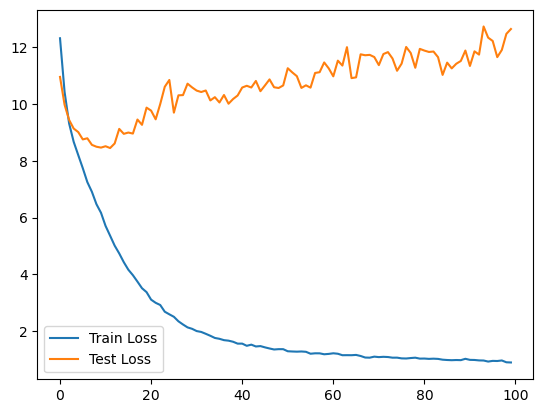

In [25]:
plt.plot(range(len(loss_train_means)), loss_train_means, label = 'Train Loss')
plt.plot(range(len(loss_test_means)), loss_test_means, label = 'Test Loss')
plt.legend()

In [46]:
p = 'model_weights/chanest_cemse_{}_{}_{}_{}_*'.format(min_loss_test_epoch, *min_loss_test_params)
g = glob.glob(p)
model_path = g[0]
model_path

'model_weights/chanest_cemse_12_0.0001_rmsprop_0.0_5.359802652300371_8.452034436512395.pth'

In [47]:
model = ChannelEstimationNetworkCEMSE(min_loss_test_params[2])
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

(np.float64(7.340905227528246), (0.001, 'adagrad', 0.1), np.int64(78))

In [28]:
(model, loss_train_means, loss_test_means) = results_map_mse[min_loss_test_params]

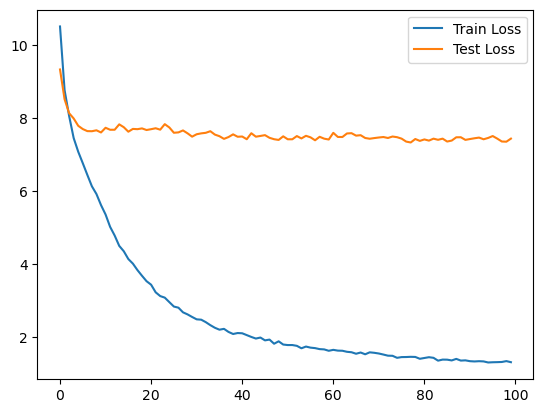

In [29]:
plt.plot(range(len(loss_train_means)), loss_train_means, label = 'Train Loss')
plt.plot(range(len(loss_test_means)), loss_test_means, label = 'Test Loss')
plt.legend()